In [66]:
import math
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [67]:
df = pd.read_csv("train.csv")
df.head()

,center,angle
0,/Users/lacho/sdcnd/Self-Driving-Car-Simulator/...,0.000000
1,/Users/lacho/sdcnd/Self-Driving-Car-Simulator/...,0.000000
2,/Users/lacho/sdcnd/Self-Driving-Car-Simulator/...,0.000000
3,/Users/lacho/sdcnd/Self-Driving-Car-Simulator/...,-0.088554
4,/Users/lacho/sdcnd/Self-Driving-Car-Simulator/...,-0.382704


In [68]:
# df['use'] = np.random.randint(0,11, size=df.shape[0]) > 7
# df = df[df.use | df.angle != 0]

0.506853688647
-1.0 1.0


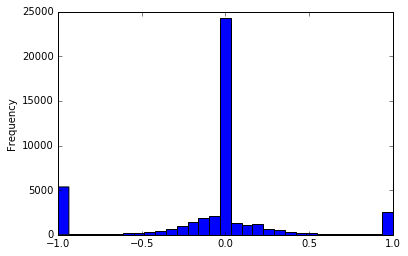

In [69]:
print(df.angle[df.angle != 0].count() / df.shape[0])
print(df.angle.min(), df.angle.max())
df.angle.plot(kind='hist', bins=31);

In [70]:
print('train samples:', df.shape[0])

train samples: 46982


In [71]:
def load_img(path, resize=True, crop_top=20, crop_bottom=-1):
    try:
        img = cv2.imread(path)

        if resize:
            img = cv2.resize(img,(160, 80), interpolation = cv2.INTER_CUBIC)
        if crop_top:
            img = img[crop_top:crop_bottom, :] 
    except:
        print(path)
        raise
    return img 

def ld_img(img):
#     return load_img(img, resize=True, crop_top=30, crop_bottom=-10)
#     return load_img(img, resize=False, crop_top=60, crop_bottom=-15)
    return load_img(img, resize=False, crop_top=60, crop_bottom=-1)

In [72]:
def data_generator(df, batch_size=64, iterations=1000000):
    for i in range(iterations):
        s = df.sample(batch_size)
        
        imgs = np.array([ld_img(im) for im in s.center.values])
        angles = s.angle.values
        imgs[:int(batch_size/2)] = [np.fliplr(im) for im in imgs[:int(batch_size/2)]]
        angles[:int(batch_size/2)] = -angles[:int(batch_size/2)]
        yield (imgs, angles)

def normalize(x):
    return x / 255.0 - 0.5

In [73]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K

In [74]:
img = ld_img(df.center.iloc[0])
input_shape = img.shape
print(input_shape)

# 
# model.add(Activation('tanh'))
# model.add(Dropout(0.5))

model = Sequential()
model.add(Lambda(normalize, input_shape=input_shape))
model.add(Convolution2D(16, 5, 5, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Convolution2D(32, 5, 5, subsample=(2, 4), border_mode='valid', activation='elu'))
model.add(Convolution2D(32, 5, 5, subsample=(4, 8), border_mode='valid', activation='elu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

adam = Adam(lr=0.0001)

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mse'])

model.summary()

(99, 320, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_12 (Lambda)               (None, 99, 320, 3)    0           lambda_input_12[0][0]            
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 48, 158, 16)   1216        lambda_12[0][0]                  
____________________________________________________________________________________________________
convolution2d_33 (Convolution2D) (None, 22, 39, 32)    12832       convolution2d_32[0][0]           
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 5, 5, 32)      25632       convolution2d_33[0][0]           
______________________________________________________________________________

In [75]:
import json

def save_model(model, file_name='model'):
    model.save_weights('{}.h5'.format(file_name))
    with open('{}.json'.format(file_name), 'w') as file:
        json.dump(model.to_json(), file)
    print('model saved at', file_name)

In [81]:
df_train, df_test = train_test_split(df, test_size=0.05, random_state=3)
df_train = df_train.copy()
print(df_train.shape, df_test.shape)

(44632, 2) (2350, 2)


In [82]:
df_train['random'] = np.random.randint(0,10, df_train.shape[0])
df_train = df_train[(df_train.angle != 0) | (df_train.random > 7)]
print(df_train.shape)

(26981, 3)


In [86]:

batch_size = 64
samples = batch_size * int(df_train.shape[0] / batch_size / 10)
epochs = 10

history = model.fit_generator(data_generator(df_train, batch_size), 
                              validation_data=data_generator(df_test, batch_size), 
                              nb_val_samples=df_test.shape[0] /10,
                              samples_per_epoch=samples, nb_epoch=epochs)
save_model(model)

Epoch 1/10
2688/2688 [==============================] - 30s - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 2/10
2688/2688 [==============================] - 34s - loss: 0.0827 - mean_squared_error: 0.0827 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 3/10
2688/2688 [==============================] - 33s - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 4/10
2688/2688 [==============================] - 36s - loss: 0.0783 - mean_squared_error: 0.0783 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 5/10
2688/2688 [==============================] - 30s - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 6/10
2688/2688 [==============================] - 52s - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 7/10
2688/2688 [==============================] - 50s - lo

In [44]:
save_model(model)

model saved at model


In [84]:
history.history

{'loss': [0.27006505749055315,
  0.1829855175954955,
  0.16110731643580256,
  0.1360884133194174,
  0.12931195433650697,
  0.11126858155642237,
  0.11580062746292069,
  0.10805851442828066,
  0.1099702458651293,
  0.095897691856537542],
 'mean_squared_error': [0.27006505749055315,
  0.1829855175954955,
  0.16110731643580256,
  0.1360884133194174,
  0.12931195433650697,
  0.11126858155642237,
  0.11580062746292069,
  0.10805851442828066,
  0.1099702458651293,
  0.095897691856537542],
 'val_loss': [0.11993313394486904,
  0.10155690275132656,
  0.086702385917305946,
  0.12166860327124596,
  0.073379624634981155,
  0.10328422486782074,
  0.066233729477971792,
  0.074403733015060425,
  0.087562229484319687,
  0.059810984414070845],
 'val_mean_squared_error': [0.11993313394486904,
  0.10155690275132656,
  0.086702385917305946,
  0.12166860327124596,
  0.073379624634981155,
  0.10328422486782074,
  0.066233729477971792,
  0.074403733015060425,
  0.087562229484319687,
  0.059810984414070845]}